### **1. Introduction & Learning Objectives**

In the previous notebook, we learned how **autoencoders** work — how they compress and reconstruct facial images, and how the latent space captures meaningful features such as symmetry, emotion, and shape.  
We now take the next step: applying those insights to **real-world problems**.

Autoencoders are not just theoretical constructs — their ability to reconstruct inputs with varying accuracy can be used for **practical applications**.  
In this notebook, we will focus on two of the most common and powerful ones:

1. **Anomaly Detection:**  
   Detecting unfamiliar or rare expressions by analyzing reconstruction error.  
   When the autoencoder encounters a face it hasn’t learned before, it typically fails to reconstruct it accurately — signaling an anomaly.

2. **Denoising Autoencoder:**  
   Training the model to remove noise from corrupted inputs.  
   This demonstrates how autoencoders can learn *robust, structure-preserving representations* of data.

> Through these applications, we will see how the reconstruction process becomes not only a way to measure how well the model has learned, but also a **tool** for identifying novelty and restoring degraded data.

**Learning Goals**

By the end of this notebook, we will be able to:

- **Understand** how reconstruction error reflects the model’s familiarity with data.  
- **Apply** this insight to perform **anomaly detection** using facial expressions.  
- **Extend** the autoencoder concept into a **denoising framework** that can reconstruct clean images from noisy inputs.

> This notebook moves us from *understanding representations* to *applying them*, bridging the gap between unsupervised learning theory and its practical uses in generative modeling.


---

### **2. Revisiting the Autoencoder Model**

Before we apply the autoencoder to new tasks, let’s briefly revisit the model we built in the previous notebook.

Our **fully connected autoencoder (FC_AE)** had a simple yet powerful structure designed to learn a compressed representation of each 48×48 grayscale face image.  
It consisted of two main parts:

- **Encoder:** Compresses the input image (a 2,304-dimensional vector) into a smaller **latent representation** — capturing essential features like overall facial structure and emotion-related cues.  
- **Decoder:** Expands the latent representation back into the original image size — aiming to reconstruct the input as closely as possible.

> In essence, the autoencoder learns an *efficient code* for faces — much like summarizing the most important characteristics needed to recreate them.

**Purpose in This Notebook**

In this notebook, we will **reuse the same architecture** from Notebook 1.  
However, our *objectives* will change:
- Instead of simply reconstructing any input image, we’ll observe how reconstruction behaves under **new scenarios** — when data is unfamiliar (for anomaly detection) or corrupted (for denoising).  

Thus, the model structure remains the same; what changes is **how we use it**.

**Code Overview**

1. **Import and initialize** the `FC_Autoencoder` class from our previous implementation.  
2. **Optionally load saved weights** if we trained a model earlier.  
3. **Verify input–output consistency** using a dummy tensor to ensure dimensions match.

In [25]:
import torch
import torch.nn as nn

# Define the same architecture used in Notebook 1
class FC_Autoencoder(nn.Module):
    def __init__(self):
        super(FC_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(48 * 48, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 48 * 48),
            nn.Sigmoid()   # constrain outputs to [0, 1]
        )

    def forward(self, x):
        x = x.view(-1, 48 * 48)
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(-1, 1, 48, 48)
        return out

# Initialize model
model = FC_Autoencoder()

# Optional: Load trained weights if available
# model.load_state_dict(torch.load("fc_autoencoder.pth", map_location='cpu'))

# Confirm input–output shape consistency
dummy_input = torch.randn(1, 1, 48, 48)
dummy_output = model(dummy_input)
print(f"Input shape: {dummy_input.shape}, Output shape: {dummy_output.shape}")


Input shape: torch.Size([1, 1, 48, 48]), Output shape: torch.Size([1, 1, 48, 48])


> Notice that we are not redesigning the network.
> We are reusing the same autoencoder, but applying it to new and insightful problems — reinforcing the versatility of this simple architecture.

---

### **3. Anomaly Detection – Conceptual Overview**

In this section, we explore how **autoencoders can be used for anomaly detection** — a fascinating real-world application of unsupervised learning.

The underlying principle is simple yet powerful:

> An autoencoder trained on **familiar data** (faces or expressions it has seen during training) learns to reconstruct them accurately.  
> However, when it encounters **unseen or unusual patterns**, it struggles — leading to a **higher reconstruction error**.

This difference in reconstruction quality provides a useful **signal for anomaly detection**.

**Key Intuition**

Let’s imagine we train our autoencoder on a subset of common facial expressions such as:

- 😀 **Happy**
- 😐 **Neutral**
- 😢 **Sad**
- 😮 **Surprise**
- 😠 **Angry**

These are the “known” emotions — the model becomes familiar with their general structure.

Now, when we feed it unfamiliar expressions like:

- 😱 **Fear**
- 🤢 **Disgust**

the model cannot represent them well in its latent space, resulting in **blurred reconstructions** and **larger reconstruction errors**.

Hence:

- **Known emotions →** low reconstruction error  
- **Unknown emotions →** high reconstruction error  

This behavior allows us to *quantify unfamiliarity* using reconstruction loss as a proxy for novelty.

**Mathematical Expression**

The **reconstruction error** for an input image $ x $ and its reconstruction $ \hat{x} $ is computed as:

$$
\text{Reconstruction Error} = \| x - \hat{x} \|^2
$$

This measures the pixel-wise difference — the larger the error, the less familiar the image is to the autoencoder.

**Conceptual Flow**

Below is a schematic overview of the process:

```text
Input Image ──► Encoder ──► Latent Space ──► Decoder ──► Reconstructed Image
      │                                                       │
      └───────────────────── Compute Reconstruction Error ────┘
```





The **latent space** acts as a learned representation of “normal” data.  
When a new image doesn’t fit well within that representation, the **error increases**, flagging it as an anomaly.

> In the next section, we will train our autoencoder on *common emotions* and then test it on *rare or unseen emotions* to see this phenomenon in action.

---

### **4. Training for Anomaly Detection**

Our goal is to train an autoencoder only on **common emotions** so that it becomes familiar with those patterns. Later, we will test it on **rare or unseen emotions** and compare reconstruction errors.

- **Known emotions for training:** happy, neutral, sad, surprise, angry  
- **Unknown emotions for testing (anomalies):** fear, disgust

We ensure that the training subset is **balanced** across the known classes so the model does not overfit to any single expression style.

**Data Preparation (filter, balance, split)**

**FER2013 label convention:**  
0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral

- Known (train): {0, 3, 4, 5, 6}  
- Unknown (anomalies at test time): {1, 2}

In [26]:
import numpy as np
from collections import Counter

# Load the downsampled dataset if not already in memory
try:
    X, y
except NameError:
    data = np.load("fer2013_small.npz")
    X, y = data["X"], data["y"]

known_labels = {0, 3, 4, 5, 6}    # angry, happy, sad, surprise, neutral
unknown_labels = {1, 2}           # disgust, fear

# Filter known subset
mask_known = np.isin(y, list(known_labels))
X_known, y_known = X[mask_known], y[mask_known]

# Optional: balance known classes by undersampling to the minimum class count
counts = Counter(y_known.tolist())
min_count = min(counts.values())
idx_balanced = []

# collect min_count indices per class
for lbl in sorted(known_labels):
    idx_lbl = np.where(y_known == lbl)[0]
    choose = np.random.choice(idx_lbl, size=min_count, replace=False)
    idx_balanced.append(choose)

idx_balanced = np.concatenate(idx_balanced, axis=0)
np.random.shuffle(idx_balanced)

X_known_bal = X_known[idx_balanced]
y_known_bal = y_known[idx_balanced]

print("Balanced known class counts:",
      Counter(y_known_bal.tolist()))
print("X_known_bal shape:", X_known_bal.shape)


Balanced known class counts: Counter({6: 1285, 5: 1285, 3: 1285, 4: 1285, 0: 1285})
X_known_bal shape: (6425, 48, 48)


Now we split the known subset into train/test, stratified by emotion to preserve class balance.

In [34]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

Xk_train, Xk_test, yk_train, yk_test = train_test_split(
    X_known_bal, y_known_bal, test_size=0.15, random_state=42, stratify=y_known_bal
)

# Convert to torch tensors with channel dimension (N, 1, 48, 48)
Xk_train_t = torch.tensor(Xk_train, dtype=torch.float32).unsqueeze(1)
Xk_test_t  = torch.tensor(Xk_test,  dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(Xk_train_t)   # labels not used for AE training
test_ds  = TensorDataset(Xk_test_t)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)


(43, 8)

**Define Loss and Optimizer**

We keep the same reconstruction objective and optimizer as before: MSELoss and Adam.

In [35]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # reuse FC_Autoencoder from Section 2

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


**Train**

We print average train and test reconstruction loss per epoch.</br>
Decreasing loss indicates that $\hat{x}$ is getting closer to $x$, meaning the model is learning a compact representation of the known emotions.

In [36]:
from math import inf

EPOCHS = 100
best_test = inf
best_state = None

for epoch in range(1, EPOCHS + 1):
    # ----- Train -----
    model.train()
    train_sum = 0.0
    for (xb,) in train_loader:
        xb = xb.to(device)
        optimizer.zero_grad()
        xhat = model(xb)
        loss = criterion(xhat, xb)
        loss.backward()
        optimizer.step()
        train_sum += loss.item() * xb.size(0)
    train_avg = train_sum / len(train_ds)

    # ----- Eval on held-out known data -----
    model.eval()
    test_sum = 0.0
    with torch.no_grad():
        for (xb,) in test_loader:
            xb = xb.to(device)
            xhat = model(xb)
            loss = criterion(xhat, xb)
            test_sum += loss.item() * xb.size(0)
    test_avg = test_sum / len(test_ds)

    print(f"Epoch {epoch:02d} | train MSE: {train_avg:.5f} | test MSE: {test_avg:.5f}")

    if test_avg < best_test:
        best_test = test_avg
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Restore best weights (recommended before anomaly evaluation)
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01 | train MSE: 0.02538 | test MSE: 0.01403
Epoch 02 | train MSE: 0.01150 | test MSE: 0.01207
Epoch 03 | train MSE: 0.01051 | test MSE: 0.01184
Epoch 04 | train MSE: 0.01013 | test MSE: 0.01103
Epoch 05 | train MSE: 0.00986 | test MSE: 0.01081
Epoch 06 | train MSE: 0.00983 | test MSE: 0.01078
Epoch 07 | train MSE: 0.00961 | test MSE: 0.01065
Epoch 08 | train MSE: 0.00949 | test MSE: 0.01068
Epoch 09 | train MSE: 0.00953 | test MSE: 0.01050
Epoch 10 | train MSE: 0.00941 | test MSE: 0.01065
Epoch 11 | train MSE: 0.00937 | test MSE: 0.01041
Epoch 12 | train MSE: 0.00931 | test MSE: 0.01035
Epoch 13 | train MSE: 0.00927 | test MSE: 0.01043
Epoch 14 | train MSE: 0.00919 | test MSE: 0.01026
Epoch 15 | train MSE: 0.00923 | test MSE: 0.01036
Epoch 16 | train MSE: 0.00923 | test MSE: 0.01025
Epoch 17 | train MSE: 0.00907 | test MSE: 0.01026
Epoch 18 | train MSE: 0.00910 | test MSE: 0.01050
Epoch 19 | train MSE: 0.00907 | test MSE: 0.01022
Epoch 20 | train MSE: 0.00901 | test MSE: 0.01022


**What the loss trends mean**

- When training loss decreases, the model is improving its ability to reconstruct the known emotion images it sees during training.

- When test loss also decreases, the model is not merely memorizing but learning a general reconstruction strategy for the known emotions.

- In the next section, we will compute reconstruction errors for unknown emotions (fear, disgust) and compare them to the known ones to observe the anomaly effect.

---

### **5. Anomaly Detection – Evaluation & Visualization**

We will now **quantify** and **visualize** the anomaly effect.  
The expectation is straightforward: when the model sees images that come from emotions it was **trained on** (known), it reconstructs them well, leading to **low reconstruction error**.  
When it sees **unseen** emotions (unknown), it struggles, producing **higher reconstruction error**.

> In other words, reconstruction error acts as an indicator of **novelty**: the autoencoder “knows” what it has seen before.

**Compute Reconstruction Errors (Known vs Unknown)**

We will compute per-image reconstruction error as the mean squared difference between $x$ and $\hat{x}$:
$$
\text{err}(x,\hat{x}) = \frac{1}{HW}\sum_{p}(x_p - \hat{x}_p)^2
$$
where $H=W=48$ for FER2013 faces.


In [37]:
import numpy as np
import torch
from collections import Counter

# Ensure we have: model (trained on known classes), device, and the full X, y arrays
try:
    X, y
except NameError:
    data = np.load("fer2013_small.npz")
    X, y = data["X"], data["y"]

known_labels = {0, 3, 4, 5, 6}   # angry, happy, sad, surprise, neutral
unknown_labels = {1, 2}          # disgust, fear

# Build known/unknown tensors
idx_known_eval = np.isin(y, list(known_labels))
idx_unknown_eval = np.isin(y, list(unknown_labels))

X_known_eval = torch.tensor(X[idx_known_eval], dtype=torch.float32).unsqueeze(1)
X_unknown_eval = torch.tensor(X[idx_unknown_eval], dtype=torch.float32).unsqueeze(1)

def reconstruction_errors(batch_tensor):
    """
    Compute per-image MSE reconstruction error in [0, 1] space.
    Returns a 1D numpy array of length N.
    """
    errs = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(batch_tensor), 256):
            xb = batch_tensor[i:i+256].to(device)
            xhat = model(xb)
            # Per-image MSE over HxW (not batch-averaged)
            e = (xhat - xb).pow(2).mean(dim=(1,2,3))  # (N,)
            errs.append(e.cpu().numpy())
    return np.concatenate(errs, axis=0)

errs_known = reconstruction_errors(X_known_eval)
errs_unknown = reconstruction_errors(X_unknown_eval)

print("Known eval count  :", len(errs_known))
print("Unknown eval count:", len(errs_unknown))
print("Known error stats :", np.mean(errs_known), np.median(errs_known))
print("Unknown error stats:", np.mean(errs_unknown), np.median(errs_unknown))


Known eval count  : 6425
Unknown eval count: 1832
Known error stats : 0.0071064136 0.0065937038
Unknown error stats: 0.008788402 0.007857138


**Histograms of Reconstruction Errors**

We will visualize the error distributions for known vs unknown samples.</br>
If the anomaly effect is present, the unknown distribution will be shifted to the right (higher errors).

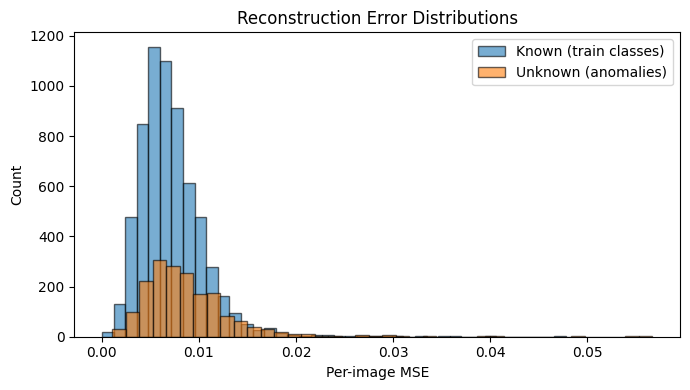

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
bins = 40
plt.hist(errs_known, bins=bins, alpha=0.6, label="Known (train classes)", edgecolor="black")
plt.hist(errs_unknown, bins=bins, alpha=0.6, label="Unknown (anomalies)", edgecolor="black")
plt.title("Reconstruction Error Distributions")
plt.xlabel("Per-image MSE")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


> We expect the known histogram to concentrate at lower errors, whereas the unknown histogram should have a heavier tail at higher errors.

**Optional: Thresholding and AUC**

For a simple threshold, we can choose the 95th percentile of known errors.</br>
Anything above this threshold can be flagged as “anomalous”.

We also compute the ROC AUC as a summary metric (1.0 = perfect separation, 0.5 = chance).

95th percentile threshold (known errors): 0.012664432823657978
ROC AUC (known vs unknown): 0.6137814130120809


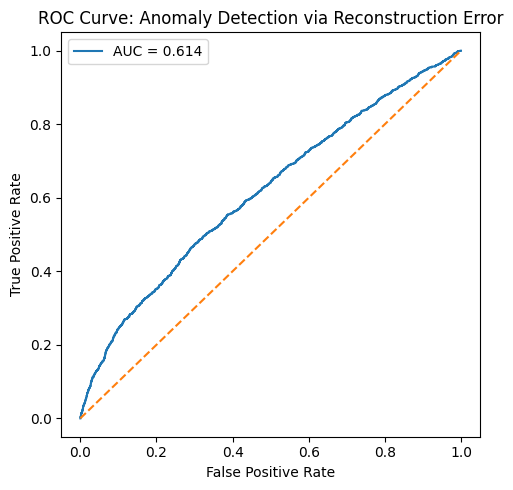

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve

# Simple threshold: 95th percentile of known errors
thr = np.percentile(errs_known, 95)
print("95th percentile threshold (known errors):", float(thr))

# Build labels and scores for ROC AUC
y_true = np.concatenate([np.zeros_like(errs_known), np.ones_like(errs_unknown)])  # 0=known, 1=unknown
y_score = np.concatenate([errs_known, errs_unknown])

auc = roc_auc_score(y_true, y_score)
print("ROC AUC (known vs unknown):", float(auc))

# Optional: ROC curve points
fpr, tpr, _ = roc_curve(y_true, y_score)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Anomaly Detection via Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.show()

**Side-by-Side Reconstructions (Known vs Unknown)**

We visualize why errors differ by placing originals and reconstructions side-by-side.

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def _to_nchw_float32(x):
    """
    Accepts numpy or torch arrays in shape:
      - (N, 48, 48)  or
      - (N, 1, 48, 48)
    Returns torch.FloatTensor on model.device with shape (N, 1, 48, 48).
    """
    device = next(model.parameters()).device
    # If torch tensor, move to CPU for shape checks
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()

    x = np.asarray(x)
    if x.ndim == 3 and x.shape[1:] == (48, 48):
        x = x[:, None, :, :]  # add channel dim -> (N,1,48,48)
    elif x.ndim == 4 and x.shape[1:] == (1, 48, 48):
        pass  # already (N,1,48,48)
    else:
        raise ValueError(f"Expected (N,48,48) or (N,1,48,48), got {x.shape}")

    xt = torch.tensor(x, dtype=torch.float32, device=device)
    return xt

def recon_pairs(XA, title_left, XB, title_right, n=5):
    """
    Robust side-by-side original vs reconstruction for two groups.
    Accepts XA/XB as numpy arrays or torch tensors with shape (N,48,48) or (N,1,48,48).
    """
    n = min(n, len(XA), len(XB))
    model.eval()

    A = _to_nchw_float32(XA[:n])
    B = _to_nchw_float32(XB[:n])

    with torch.no_grad():
        Ah = model(A).cpu().numpy()
        Bh = model(B).cpu().numpy()
        A  = A.cpu().numpy()
        B  = B.cpu().numpy()

    fig, axes = plt.subplots(n, 4, figsize=(8, 2*n))
    for i in range(n):
        axes[i, 0].imshow(A[i, 0], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, 0].set_title(f"{title_left} (orig)", fontsize=9); axes[i, 0].axis("off")

        axes[i, 1].imshow(Ah[i, 0], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, 1].set_title(f"{title_left} (recon)", fontsize=9); axes[i, 1].axis("off")

        axes[i, 2].imshow(B[i, 0], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, 2].set_title(f"{title_right} (orig)", fontsize=9); axes[i, 2].axis("off")

        axes[i, 3].imshow(Bh[i, 0], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, 3].set_title(f"{title_right} (recon)", fontsize=9); axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()


Then call it like this (no .unsqueeze or .numpy() gymnastics needed):

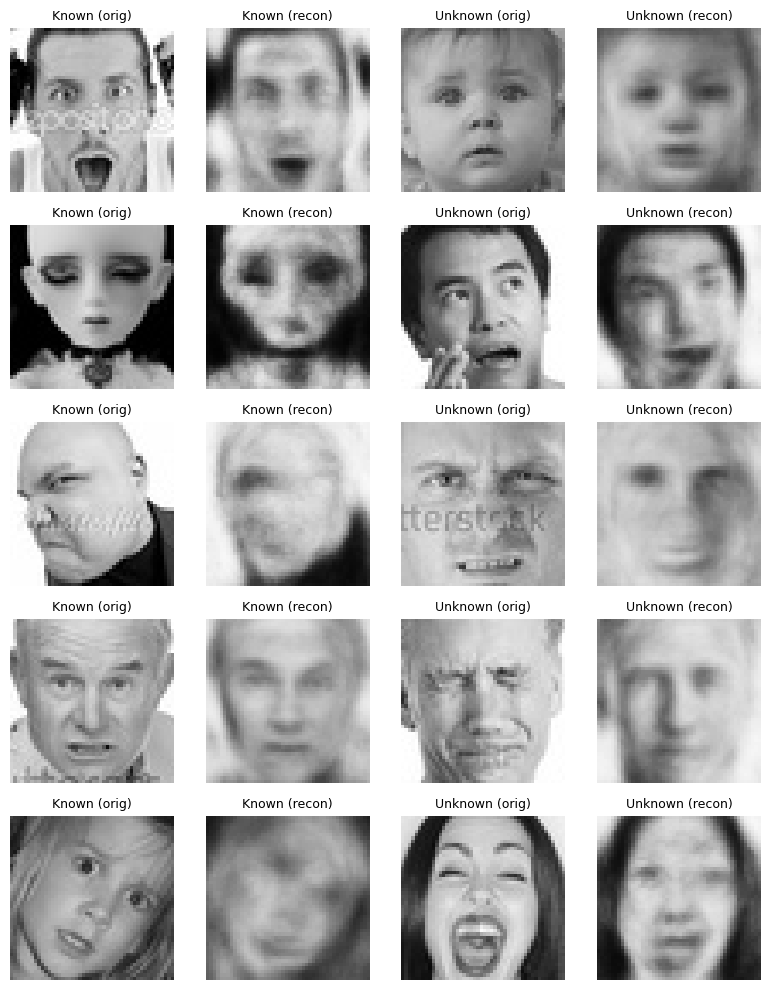

In [43]:
# If we already have torch tensors from earlier:
# X_known_eval and X_unknown_eval are (N,1,48,48) torch tensors
recon_pairs(X_known_eval, "Known", X_unknown_eval, "Unknown", n=5)

# If we have numpy arrays (e.g., from np.load):
# recon_pairs(X_known_np, "Known", X_unknown_np, "Unknown", n=5)


> Known faces usually preserve mouth curves, eye lines, and the overall head contour, while unknown faces often look smoother or distorted — the model has not internalized their structure.

**Error by Class (Bar Plot or Box Plot)**

We can break down mean reconstruction error by emotion class to see which categories are easier or harder to reconstruct.

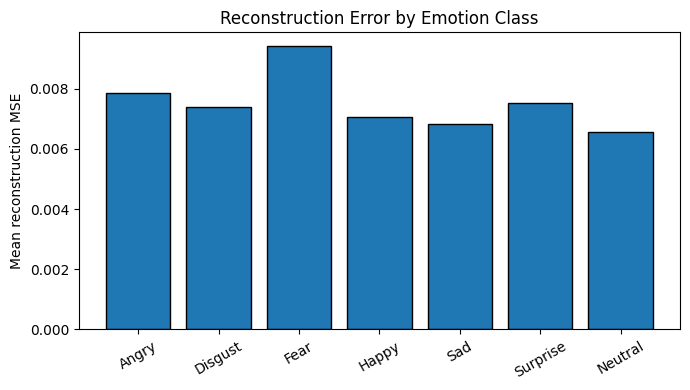

C:\Users\noman\AppData\Local\Temp\ipykernel_13664\1840624990.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d for d in data_for_box if len(d)>0], labels=[l for l,d in zip(labels, data_for_box) if len(d)>0], showfliers=False)


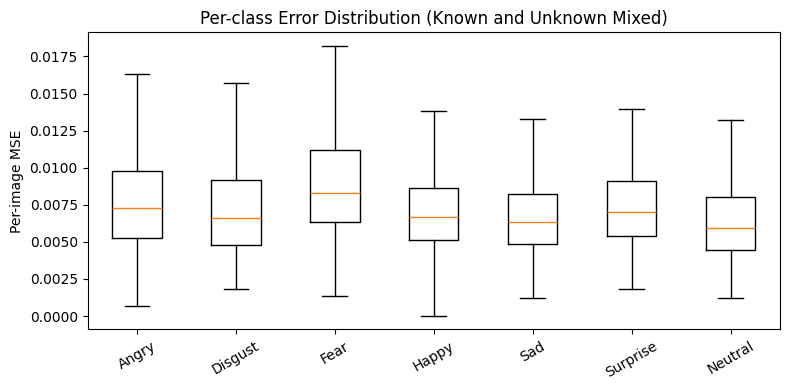

In [44]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

def per_class_errors(X_all, y_all, max_per_class=400):
    errs_by_cls = {}
    for lbl in range(7):
        idx = np.where(y_all == lbl)[0]
        if len(idx) == 0:
            continue
        if len(idx) > max_per_class:
            idx = np.random.choice(idx, size=max_per_class, replace=False)
        errs = reconstruction_errors(torch.tensor(X_all[idx], dtype=torch.float32).unsqueeze(1))
        errs_by_cls[lbl] = errs
    return errs_by_cls

errs_cls = per_class_errors(X, y, max_per_class=400)

# Bar plot of class-wise means
means = [errs_cls[k].mean() if k in errs_cls else np.nan for k in range(7)]
plt.figure(figsize=(7,4))
plt.bar(labels, means, edgecolor="black")
plt.xticks(rotation=30)
plt.ylabel("Mean reconstruction MSE")
plt.title("Reconstruction Error by Emotion Class")
plt.tight_layout()
plt.show()

# Optional: box plot to show spread
data_for_box = [errs_cls.get(k, np.array([])) for k in range(7)]
plt.figure(figsize=(8,4))
plt.boxplot([d for d in data_for_box if len(d)>0], labels=[l for l,d in zip(labels, data_for_box) if len(d)>0], showfliers=False)
plt.xticks(rotation=30)
plt.ylabel("Per-image MSE")
plt.title("Per-class Error Distribution (Known and Unknown Mixed)")
plt.tight_layout()
plt.show()


**Interpretation**

- Known emotions should reconstruct with lower errors, indicating the latent space represents them well.
- Unknown emotions should produce higher errors and blurrier reconstructions, suggesting a mismatch with the learned manifold.
- The separation we observe in error distributions supports using reconstruction error as a proxy for novelty.

In the next section, we will shift from detecting anomalies to removing noise, training a denoising autoencoder that reconstructs clean faces from corrupted inputs.

---

### **6. Transition to Denoising Autoencoders**

So far, we have seen how **autoencoders can detect anomalies** by measuring reconstruction error — the model “knows” what it has seen before.  
Now we shift our focus from **detecting what’s different** to **correcting what’s distorted**.

This brings us to the concept of **denoising autoencoders (DAEs)** — a powerful variant designed to **recover clean data from noisy or corrupted inputs**.

**6.1 Conceptual Motivation**

Imagine taking a clear facial image and adding random noise to it — perhaps a few pixels are corrupted, or the image looks slightly grainy.  
A denoising autoencoder learns to **filter out this noise** and **reconstruct the original, clean face**.  

This ability makes DAEs more than just reconstruction tools — they become **robust feature learners**, capable of understanding the essential structure of the data.

> In practice, this robustness helps downstream models perform better on imperfect or real-world data.

**6.2 How It Works**

We start with an original input image $x$.  
We then create a **noisy version** $x'$ by adding some random Gaussian noise:

- **Input to the model:** $x'$ (corrupted image)  
- **Target output:** $x$ (clean original image)  
- **Predicted output:** $\hat{x} = f_\theta(x')$

The model is trained to minimize the difference between the clean target and its reconstruction of the noisy input.

**6.3 Objective Function**

The loss function captures how close the reconstructed clean face $\hat{x}$ is to the true clean face $x$:

$$
L = | x - f_\theta(x') |^2
$$

This encourages the network to *ignore noise* and focus on the stable, consistent features that define the underlying facial structure.

**6.4 Intuitive Analogy**

We can think of the denoising autoencoder as a **digital restorer**:
- It sees an image “through the fog” (noise).  
- It learns what features truly matter — like the curve of a smile or the outline of the eyes — to **recover clarity**.  
- Over time, it becomes resistant to superficial distortions.

This process also improves the **quality of learned representations**, since the model learns to rely on *stable features* rather than pixel-level details.

**6.5 Connection to Learning Robust Representations**

By forcing the model to reconstruct the *clean version* from *noisy inputs*, we implicitly teach it to:
- Focus on **global structure** over fine noise patterns.
- Develop a **smoother latent space** — where small input changes don’t cause large representation changes.
- Generalize better to unseen or imperfect data.

> In other words, denoising acts as a **form of regularization**, strengthening the model’s understanding of essential data features — a stepping stone toward more advanced generative models like **Variational Autoencoders (VAEs)** and **GANs**.

✅ **Up next:** We will implement a Denoising Autoencoder (DAE) on the FER2013 dataset — first by corrupting the inputs with random Gaussian noise, then training the network to reconstruct clean faces.

---

### **7. Building a Denoising Autoencoder**

We now turn our autoencoder into a **denoising autoencoder (DAE)**.  
The idea is simple: we deliberately corrupt clean images with random noise and train the network to reconstruct the **clean targets**.  
By learning to map noisy inputs to clean outputs, the model focuses on **essential structure** rather than pixel-level noise.

> We will add Gaussian noise to training images, keep pixel values in $[0, 1]$, and reuse the same architecture. The only change is the training objective: input is noisy, target is clean.

**7.1 Prepare Noisy Inputs and Clean Targets**

In [45]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# If train/test splits are not in memory, recreate them from Section 4 defaults
try:
    Xk_train, Xk_test
except NameError:
    # Fallback: use the full dataset split if needed
    data = np.load("fer2013_small.npz")
    X_all, y_all = data["X"], data["y"]
    from sklearn.model_selection import train_test_split
    Xk_train, Xk_test, yk_train, yk_test = train_test_split(
        X_all, y_all, test_size=0.15, random_state=42, stratify=y_all
    )

# Add Gaussian noise to training inputs
noise_factor = 0.3
rng = np.random.default_rng(42)

X_noisy_train = Xk_train + noise_factor * rng.standard_normal(Xk_train.shape)
X_noisy_train = np.clip(X_noisy_train, 0.0, 1.0)

# Validation set can also be evaluated with noisy inputs
X_noisy_test = Xk_test + noise_factor * rng.standard_normal(Xk_test.shape)
X_noisy_test = np.clip(X_noisy_test, 0.0, 1.0)

# Tensors: inputs are noisy, targets are clean
X_tr_in  = torch.tensor(X_noisy_train, dtype=torch.float32).unsqueeze(1)
X_tr_tgt = torch.tensor(Xk_train,      dtype=torch.float32).unsqueeze(1)

X_te_in  = torch.tensor(X_noisy_test, dtype=torch.float32).unsqueeze(1)
X_te_tgt = torch.tensor(Xk_test,      dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_tr_in, X_tr_tgt)
test_ds  = TensorDataset(X_te_in, X_te_tgt)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)

(43, 8)

**7.2 Reuse the Same Autoencoder Architecture**

In [46]:
import torch.nn as nn

class FC_Autoencoder(nn.Module):
    def __init__(self, input_dim=48*48, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, latent_dim),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: (N, 1, 48, 48)
        n = x.size(0)
        x_flat = x.view(n, -1)
        z = self.encoder(x_flat)
        x_hat = self.decoder(z).view(n, 1, 48, 48)
        return x_hat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dae = FC_Autoencoder().to(device)


**7.3 Train With Noisy Inputs and Clean Targets**

In [49]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr=1e-3)

EPOCHS = 10
best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    # Train
    dae.train()
    run_tr = 0.0
    for xb_in, xb_tgt in train_loader:
        xb_in  = xb_in.to(device)
        xb_tgt = xb_tgt.to(device)

        optimizer.zero_grad()
        xb_hat = dae(xb_in)
        loss = criterion(xb_hat, xb_tgt)  # target is CLEAN
        loss.backward()
        optimizer.step()

        run_tr += loss.item() * xb_in.size(0)

    tr_loss = run_tr / len(train_ds)

    # Validate
    dae.eval()
    run_va = 0.0
    with torch.no_grad():
        for xb_in, xb_tgt in test_loader:
            xb_in  = xb_in.to(device)
            xb_tgt = xb_tgt.to(device)
            xb_hat = dae(xb_in)
            loss = criterion(xb_hat, xb_tgt)
            run_va += loss.item() * xb_in.size(0)

    va_loss = run_va / len(test_ds)

    print(f"Epoch {epoch:02d} | train MSE: {tr_loss:.5f} | val MSE: {va_loss:.5f}")

    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.cpu().clone() for k, v in dae.state_dict().items()}

# Restore best validation weights
if best_state is not None:
    dae.load_state_dict(best_state)


Epoch 01 | train MSE: 0.02216 | val MSE: 0.01908
Epoch 02 | train MSE: 0.01751 | val MSE: 0.01825
Epoch 03 | train MSE: 0.01719 | val MSE: 0.01793
Epoch 04 | train MSE: 0.01694 | val MSE: 0.01779
Epoch 05 | train MSE: 0.01672 | val MSE: 0.01767
Epoch 06 | train MSE: 0.01669 | val MSE: 0.01768
Epoch 07 | train MSE: 0.01653 | val MSE: 0.01755
Epoch 08 | train MSE: 0.01629 | val MSE: 0.01736
Epoch 09 | train MSE: 0.01615 | val MSE: 0.01735
Epoch 10 | train MSE: 0.01609 | val MSE: 0.01715


**7.4 Why This Works**

By feeding noisy inputs $x'$ and asking the model to produce clean outputs $x$, we force the network to learn stable, structure-focused features.
Instead of memorizing pixels, the encoder learns a representation that is resilient to noise, and the decoder learns how to reconstruct essential facial geometry.

>In practice, this improves robustness and often yields better transfer to downstream tasks. In the next section, we will visualize the effect by showing noisy inputs next to their denoised reconstructions and the original clean targets.

---

### **8. Visualizing Denoising Results**

Now that our **denoising autoencoder (DAE)** is trained, let's *see* what it has learned.  
Visualization helps us confirm whether the model has truly learned to **remove noise** while **preserving facial structure**.

We will display **triplets** of images:
> **Noisy Input → Reconstructed Output → Original Clean Image**

**Prepare a Small Batch for Visualization**

In [50]:
import matplotlib.pyplot as plt

dae.eval()
with torch.no_grad():
    xb_noisy, xb_clean = next(iter(test_loader))
    xb_noisy = xb_noisy.to(device)
    xb_clean = xb_clean.to(device)
    xb_recon = dae(xb_noisy)

# Move tensors back to CPU for visualization
noisy_np = xb_noisy[:5].cpu().squeeze(1).numpy()
recon_np = xb_recon[:5].cpu().squeeze(1).numpy()
clean_np = xb_clean[:5].cpu().squeeze(1).numpy()

**Display Noisy → Reconstructed → Original**

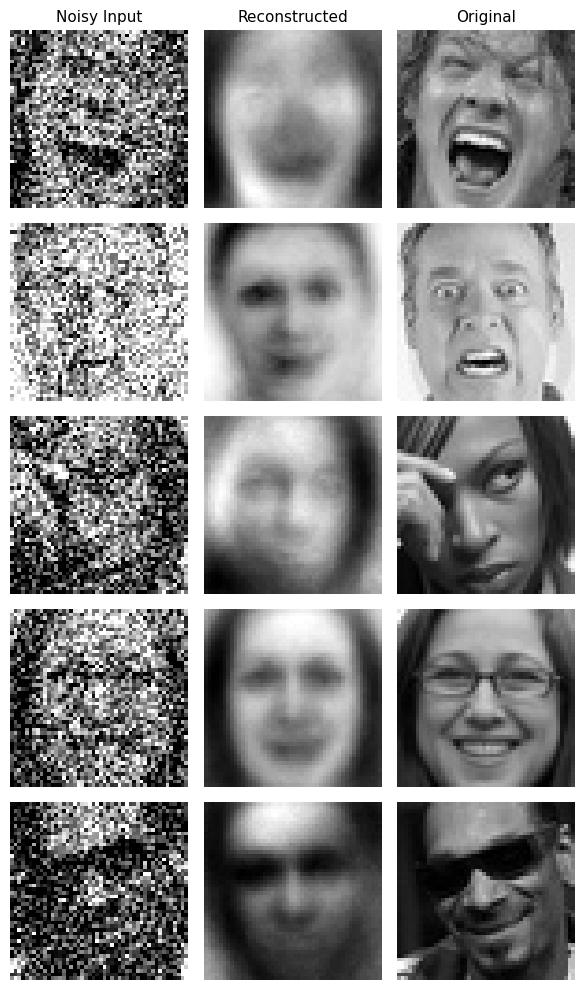

In [51]:
n_examples = 5
fig, axes = plt.subplots(n_examples, 3, figsize=(6, 10))
cols = ["Noisy Input", "Reconstructed", "Original"]

for i in range(n_examples):
    for j, img in enumerate([noisy_np[i], recon_np[i], clean_np[i]]):
        ax = axes[i, j]
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title(cols[j], fontsize=11)
plt.tight_layout()
plt.show()


As we examine the triplets:

- Noisy Inputs show random speckles or grain introduced by Gaussian noise.
- Reconstructed Outputs appear much smoother and cleaner — the autoencoder learned to filter out noise while retaining key facial features.
- Originals serve as the reference for what the model aims to recover.

> A little smoothness or blurring is expected — it reflects the model’s trade-off between removing noise and preserving detail.
The DAE prioritizes structure over texture, which is why we see stable, recognizable faces even after strong noise injection.

**Broader Insight**

This experiment mirrors real-world image restoration problems — such as photo enhancement, medical image cleaning, or pre-processing before recognition systems.
By training the network to reconstruct clarity from corruption, we help it learn robust, semantically meaningful features that generalize beyond clean data.

>In the next section, we can quantitatively compare noisy vs. reconstructed quality or explore latent-space structure to see how denoising changes representation learning.

---

### **9. Reflection & Key Takeaways**

We have now seen two powerful **applications of autoencoders** that go beyond simple reconstruction — both rooted in how the network *interprets and rebuilds* the world it has seen.

**Summary of What We Learned**

- **Autoencoders as Unsupervised Learners:**  
  They learn compressed, latent representations of data *without labels*, capturing the key structures and variations within facial images.

- **Anomaly Detection:**  
  - The reconstruction error serves as a **measure of familiarity**.  
  - Known emotions (training classes) → **low error** → the model can “rebuild” them well.  
  - Unknown emotions → **high error** → the model struggles, signaling **novelty or anomaly**.  
  - This principle extends to use cases like fault detection, fraud detection, and out-of-distribution monitoring.

- **Denoising Autoencoders:**  
  - By training on **noisy inputs** and **clean targets**, the model learns to **filter noise** and focus on **essential structure**.  
  - This process leads to **robust feature learning** — a foundation for handling imperfect or real-world data.  
  - Slight smoothness is expected: it represents stability over pixel-level precision.

> Together, these two experiments demonstrate how autoencoders can *interpret, detect, and restore* — all without explicit supervision.

**Broader Conceptual Takeaway**

Autoencoders learn to model the **manifold of normal data** — a compressed, meaningful representation of what “makes sense” in the training domain.  
When something doesn’t fit that learned structure (noise, anomalies, unseen classes), the reconstruction process exposes it.

This ability makes them invaluable in:
- **Anomaly & novelty detection**
- **Image denoising & restoration**
- **Dimensionality reduction & visualization**
- **Pretraining for deeper models**

**Looking Ahead: From AE to VAE**

In the next notebook, we’ll extend our autoencoder framework into the **Variational Autoencoder (VAE)**.  
Unlike the deterministic AE, the VAE introduces a **probabilistic latent space**, enabling:
- Sampling new faces from learned distributions  
- Smooth interpolation between different expressions  
- Generative modeling grounded in both **reconstruction** and **regularization**

> In short, we’ll move from *reconstructing existing faces* → to *generating new ones* by learning structured, continuous latent representations.

✅ **End of Notebook 2**  
We have now completed the journey from basic autoencoding to applied denoising and anomaly detection — key stepping stones toward generative deep learning.

---


### **10. Optional Exploration**

This section is for those of us who want to go a step further and explore variations or extensions of the ideas we’ve learned in this notebook.  
These are **not required** for completion but can deepen our understanding of autoencoder behavior and robustness.

**Try a Convolutional Autoencoder (CAE)**

- Replace fully connected layers with **convolutional** and **transpose-convolutional** layers.  
- Convolutional autoencoders capture **spatial patterns** and **local features**, leading to sharper reconstructions.  
- On datasets like **FER2013**, CAEs typically perform much better for both **denoising** and **anomaly detection** because they respect image structure.

> 💡 *Hint:* Replace `nn.Linear` with `nn.Conv2d` / `nn.ConvTranspose2d` and keep latent channels smaller than input.

**Experiment with Different Noise Levels**

- Adjust the noise factor to see how well the model generalizes:

In [ ]:
noise_factor = 0.1, 0.3, 0.5

- Observe:
    - At low noise, the model nearly replicates the original.
    - At high noise, reconstructions become smoother and may lose finer details.

Plot validation loss vs. noise factor to visualize robustness.

**Quantitative Anomaly Detection**

- Revisit Section 5 and compute metrics such as:
    - ROC curves
    - AUC scores
    - Precision-Recall curves

- Compare how threshold selection affects false alarms vs. missed anomalies.

> These metrics connect unsupervised reconstruction-based detection to real evaluation pipelines used in security, manufacturing, and healthcare.

**Reflect on Representation Robustness**

- How does training with noise change what the latent space encodes?
- Are features more generalizable and smooth across samples?
- Visualize embeddings (e.g., PCA or t-SNE) to inspect whether denoising helps cluster faces by emotion.

> By exploring these variations, we reinforce the central lesson:
Robust representations emerge when a model learns to ignore what doesn’t matter (noise) and focus on what does (structure).

**✅ End of Notebook 2 — Autoencoder Applications on Faces**

We have moved from basic reconstruction to meaningful applications — anomaly detection and denoising — laying the groundwork for the Variational Autoencoder (VAE) in the next notebook.